**(Dynamic) Thompson Sampling, as described in Gupta et al. - 2011 - Thompson sampling for dynamic multi-armed bandits**

> Thompson sampling is a probabilistic approach to solve the Multi-Armed Bandit. This paper modifies the original algorithm to make it handle distribution changes during the execution

The Thompson Sampling in this paper considers that each arm is a Bernoulli trial, having the output set ${0, 1}$, with $\theta^k$ denoting the probability of success for arm $k$.

The probability distribution of successes $S$ obtained in $n^k$ trials is a Binomial distribution:

$$p(S = s|\theta^k) = \binom{n^k}{s} (1-\theta^k)^{n-s}(\theta^k)^s.$$

The Beta distribution is a conjugate prior (is of the same probability distribution family as the prior probability, which is the Binomial distribution), parameterized by $\alpha_0$ and $\beta_0$:

$$p(\widehat{\theta}^k; \alpha_0, \beta_0) = \frac{x^{\alpha_0-1}(1-x)^{\beta_0-1}}{B(\alpha_0, \beta_0)},$$

with $B$ being a binonial distribution.

> We use conjugate prior to derive a closed-form expression for the posterior distribution, usually easier to interpret, manipulate and update. In Bayesian statistics, we adjust the hyperparameters of the posterior distribution to optimize the likelihood with the prior distribution.

The **original Thompson sampling** updates $\alpha_n$ and $\beta_n$ for the $n$-th trial, with reward $r_n$ as:

$$\alpha^k_ n = \alpha^k_{n-1} + r_n,$$
$$\beta^k_ n = \beta^k_{n-1} + (1-r_n).$$

The proposed method extends the original algorithm by inserting a new update rule based on an hyperparameter $C$. $C$ is a threshold that provides exponential weighting of the outcomes of the trials, making more recent rewards getting more weight. This way, if prior distributions change during the execution, the learned posterior distributions would respond to it.

We update $\alpha_n$ and $\beta_n$ conditionally based on $C$:

If $\alpha_{n-1}+\beta_{n-1}<C$, we use the original Thompson Sampling. Otherwise, we update

$$\alpha^k_ n = (\alpha^k_{n-1} + r_n)\frac{C}{C+1},$$
$$\beta^k_ n = (\beta^k_{n-1} + (1-r_n))\frac{C}{C+1}.$$

> The paper suggest initializing all $\alpha$ and $\beta$ with the value $2$ for all arms.

The remaining of the paper performs an sensitivity analysis and some experiments to check how well the Dynamic Thompson Sampling performs.

> In our work, the mutations would be the arms, and this update would be used during the evolution to adjust the mutation probabilities.

> Brush originally sample the mutations using an uniform distribution. This algorithm learns hyperparameters to Beta distributions. Somehow we need to convert them to have a transparent implementation to the user.

In [1]:
import numpy as np

class D_TS:
    def __init__(self, num_bandits, C=100):
        self.num_bandits = num_bandits

        # Store learner status when the update function is called
        self.pull_history = {
            c:[] for c in ['t', 'arm idx', 'reward', 'update'] + 
                          [f'alpha {i}' for i in range(num_bandits)] + 
                          [f'beta {i}' for i in range(num_bandits)]} 

        # This is the probability that should be used to update brush probs
        self._probabilities = np.ones(num_bandits)/num_bandits

        self._alphas = 2*np.ones(num_bandits) # Paper suggests starting with 2's
        self._betas  = 2*np.ones(num_bandits)
        self.C       = C # how to define this value???

    @property
    def probabilities(self):
        # How to transform our Beta distributions into node probabilities?
        return self._probabilities
    
    @probabilities.setter
    def probabilities(self, new_probabilities):
        if len(self._probabilities)==len(new_probabilities):
            self._probabilities = new_probabilities
        else:
            print(f"New probabilities must have size {self.num_bandits}")

    def choose_arm(self):
        """Uses the learned distributions to randomly choose an arm to pull. 
        
        Returns the index of the arm that was choosen based on the Beta
        probabilities of previous successes and fails.
        """
        
        # probability estimates from the beta distribution
        thetas = np.random.beta(self._alphas, self._betas)
        
        arm_idx = np.argmax(thetas)
        
        return arm_idx
    
    def update(self, arm_idx, reward):
        self.pull_history['t'].append( len(self.pull_history['t']) )
        self.pull_history['arm idx'].append( arm_idx )
        self.pull_history['reward'].append( reward )
        
        for i in range(self.num_bandits):
            self.pull_history[f'alpha {i}'].append( self._alphas[i] )
            self.pull_history[f'beta {i}'].append( self._betas[i] )

        if self._alphas[arm_idx] + self._betas[arm_idx] < self.C:
            # This is the pure thompson scheme
            self._alphas[arm_idx] = self._alphas[arm_idx]+reward
            self._betas[arm_idx]  = self._betas[arm_idx]+(1-reward)

            self.pull_history['update'].append( 0 )
        else:
            # This is the dynamic adjust
            self._alphas[arm_idx] = (self._alphas[arm_idx]+reward)*(self.C/(self.C+1))
            self._betas[arm_idx]  = (self._betas[arm_idx]+(1-reward))*(self.C/(self.C+1))

            self.pull_history['update'].append( 1 )

        return self

In [2]:
# Sanity checks
import pandas as pd

class Bandits:
    def __init__(self, reward_prob):
        # Implementing simple bandits.
        self.reward_prob = reward_prob # True reward prob., which learner shoudn't know
        self.n_bandits   = len(reward_prob) 

    def pull(self, arm_idx):
        # Sampling over a normal distr. with mu=0 and var=1
        result = np.random.randn()
        
        # return a positive or nullary reward (Bernoulli random variable).
        return 1 if result > self.reward_prob[arm_idx] else 0

for probs, descr, expec in [
    (np.array([ 1.0,  1.0, 1.0,  1.0]), 'All bandits with same probs'  , 'similar amount of pulls for each arm'         ),
    (np.array([-1.0,  0.2, 0.0,  1.0]), 'One bandit with higher prob'  , 'more pulls for first arm, less pulls for last'),
    (np.array([-0.2, -1.0, 0.0, -1.0]), 'Two bandits with higher probs', '2nd approx 4th > 1st > 3rd'                   ),
]:
    bandits = Bandits(probs)

    print("------------------------ optimizing ------------------------")

    learner = D_TS(4)
    for i in range(10000):
        arm_idx = learner.choose_arm()
        reward  = bandits.pull(arm_idx)

        learner.update(arm_idx, reward) 

    learner_log = pd.DataFrame(learner.pull_history).set_index('t')

    total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
    total_pulls   = learner_log['arm idx'].value_counts().to_dict()

    print("cum. reward for each arm    : ", total_rewards)
    print("number of pulls for each arm: ", total_pulls)
    print(f"(it was expected: {expec})")

------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 372, 1: 473, 2: 395, 3: 297}
number of pulls for each arm:  {1: 2976, 2: 2617, 0: 2384, 3: 2023}
(it was expected: similar amount of pulls for each arm)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 8346, 1: 4, 2: 25, 3: 1}
number of pulls for each arm:  {0: 9940, 2: 42, 1: 12, 3: 6}
(it was expected: more pulls for first arm, less pulls for last)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 9, 1: 4841, 2: 13, 3: 3552}
number of pulls for each arm:  {1: 5715, 3: 4242, 2: 24, 0: 19}
(it was expected: 2nd approx 4th > 1st > 3rd)


In [3]:
from brush.estimator import BrushEstimator
from sklearn.base import ClassifierMixin, RegressorMixin
from deap import creator
import _brush
from deap_api import nsga2 

class BrushEstimatorMod(BrushEstimator): # Modifying brush estimator
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # mutations optimized by the learner. Learner arms correspond to
        # these mutations in the order they appear here
        self.mutations_ = ['point', 'insert', 'delete', 'toggle_weight']

        # Whether the learner should update after each mutation, or if it should
        # update only after a certain number of evaluations.
        # Otherwise, it will
        # store all rewards in gen_rewards_ (which is reseted at the beggining
        # of every generation) and do a batch of updates only after finishing
        # mutating the solutions.
        self.batch_size_    = self.pop_size*2 #
        self.batch_rewards_ = []

    def _mutate(self, ind1):
        # Overriding the mutation so it updates our sampling method. Doing the
        # logic on the python-side for now.

        # Creating a wrapper for mutation to be able to control what is happening
        # in the C++ code (this should be prettier in a future implementation)
        
        params = self.get_params()
        
        ignore_this_time = True if (ind1.prg.size()+1>=self.max_size
                                    or ind1.prg.depth()+1>=self.max_depth) else False

        # Insert Mutation will not work, even if we force it, when the expression
        # is already at maximum size.
        # In this case, we'll do the mutation without controlling the probabilities.
        if ignore_this_time:
            for i, m in enumerate(self.mutations_):
                params['mutation_options'][m] = 0.25 # let cpp do the mutation 
        else:
            mutation_idx = self.learner_.choose_arm()

            for i, m in enumerate(self.mutations_):
                params['mutation_options'][m] = 0 if i != mutation_idx else 1.0

        _brush.set_params(params)
    
        opt, attempts = ind1.prg.mutate(), 0
        while attempts < 10 and opt is None:
            opt = ind1.prg.mutate()
            attempts += 1
            
        if opt is None:
            return None
        
        offspring = creator.Individual(opt)

        offspring.fitness.values = self.toolbox_.evaluate(offspring)
        
        # We compare fitnesses using the deap overloaded operators
        # from the docs: When comparing fitness values that are **minimized**,
        # ``a > b`` will return :data:`True` if *a* is **smaller** than *b*.
        # (this means that this comparison should work agnostic of min/max problems,
        # or even a single-objective or multi-objective problem)
        reward = 1.0 if offspring.fitness > ind1.fitness else 0.0
        
        if not ignore_this_time:
            self.batch_rewards_.append( (mutation_idx, reward) )

        if len(self.batch_rewards_) > self.batch_size_:
            for (mutation_idx, reward) in self.batch_rewards_:
                self.learner_.update(mutation_idx, reward)
            self.batch_rewards_ = []
        
        return offspring
    
    def fit(self, X, y):

        _brush.set_params(self.get_params())

        self.data_ = self._make_data(X,y)
        # self.data_.print()

        # set n classes if relevant
        if self.mode=="classification":
            self.n_classes_ = len(np.unique(y))

        # We have 4 different mutations, and the learner will learn to choose
        # between these options by maximizing the reward when using each one
        self.learner_ = D_TS(4, C=self.pop_size*3)

        if isinstance(self.functions, list):
            self.functions_ = {k:1.0 for k in self.functions}
        else:
            self.functions_ = self.functions

        self.search_space_ = _brush.SearchSpace(self.data_, self.functions_)

        self.toolbox_ = self._setup_toolbox(data=self.data_)

        archive, logbook = nsga2(
            self.toolbox_, self.max_gen, self.pop_size, 0.9, self.verbosity)

        self.archive_ = archive
        self.logbook_ = logbook
        self.best_estimator_ = self.archive_[0].prg

        return self
    

class BrushClassifierMod(BrushEstimatorMod,ClassifierMixin):
    def __init__( self, **kwargs):
        super().__init__(mode='classification',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.abs(data.y-ind.prg.predict(data)).sum(), 
            ind.prg.size()
        )
    
    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_classifier(self.max_depth, self.max_size)
            if self.n_classes_ == 2 else
            self.search_space_.make_multiclass_classifier(self.max_depth, self.max_size)
        )

    def predict_proba(self, X):
        data = self._make_data(X)
        return self.best_estimator_.predict_proba(data)


class BrushRegressorMod(BrushEstimatorMod, RegressorMixin):
    def __init__(self, **kwargs):
        super().__init__(mode='regressor',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.sum((data.y- ind.prg.predict(data))**2),
            ind.prg.size()
        )

    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_regressor(self.max_depth, self.max_size)
        )

## Regression problem

In [4]:
# This is needed to avoid racing conditions (https://deap.readthedocs.io/en/master/tutorials/basic/part4.html)
if __name__ == '__main__':
    from brush import BrushRegressor
    
    import warnings
    warnings.filterwarnings("ignore")

    # data = pd.read_csv('../../docs/examples/datasets/d_enc.csv')
    # X = data.drop(columns='label')
    # y = data['label']

    # data = pd.read_csv('../../docs/examples/datasets/d_2x1_subtract_3x2.csv')
    # X = data.drop(columns='target')
    # y = data['target']

    data = pd.read_csv('../../docs/examples/datasets/d_square_x1_plus_2_x1_x2_plus_square_x2.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : False,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            est     = BrushRegressor(**kwargs).fit(X,y)
            est_mab = BrushRegressorMod(**kwargs).fit(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

0, 1, 2, Input contains NaN.
3, Input contains NaN.
4, Input contains NaN.
5, Input contains NaN.
6, Input contains NaN.
7, Input contains NaN.
8, 9, Input contains NaN.
10, 11, Input contains NaN.
12, Input contains NaN.
13, Input contains NaN.
14, 15, Input contains NaN.
16, 17, 18, Input contains NaN.
19, Input contains NaN.
20, 21, 22, 23, Input contains NaN.
24, 25, 26, Input contains NaN.
27, Input contains NaN.
28, 29, 


Brush version  Original                                                      
metric            score                              best model size depth   
run 0          0.350809                   If(x1>0.91,1.61,0.38)    3     1  \
run 1          0.325058                            Cos(1.72*x2)    2     1   
run 8          0.289662                 1.54*Logistic(-1.98*x2)    2     1   
run 10         0.292958                         Square(0.96*x1)    2     1   
run 14         0.275650                         Logabs(2.31*x1)    2     1   
run 16         0.292958                        Square(-0.96*x1)    2     1   
run 17         0.292958                        Square(-0.96*x1)    2     1   
run 20         0.363372               If(x1>0.91,1.61,-0.52*x1)    3     1   
run 21         0.292958                         Square(0.96*x1)    2     1   
run 22         0.326358                       1.04*Cos(1.73*x2)    2     1   
run 24         0.314930                      0.51*Acos(1.09*x2)    2     1   
run 25         0.551982  1.01*Logistic(-130.88*Logabs(2.14*x2))    3     2   
run 28         0.325058                            Cos(1.72*x2)    2     1   
run 29         0.326358                       1.04*Cos(1.73*x2)    2     1   

Brush version  Modified                                                      
metric            score                                         best model   
run 0          0.326358                                  1.04*Cos(1.73*x2)  \
run 1          0.399693      Div(0.28*Tan(If(x1>0.91,4.61,-1.39*x1)),1.60)   
run 8          0.326358                                  1.04*Cos(1.73*x2)   
run 10         0.326358                                  1.04*Cos(1.73*x2)   
run 14         0.326358                                  1.04*Cos(1.73*x2)   
run 16         0.490733             If(x1>0.91,1.61,1.00*Square(-0.85*x1))   
run 17         0.326358                                 1.04*Cos(-1.73*x2)   
run 20         0.292958                              1.00*Square(-0.95*x1)   
run 21         0.639085  Median(If(x1>0.91,1.93,-2.94*x1),1.27,2.02*x1,...   
run 22         0.948103  Sum(If(x1>0.91,2.04,-0.85*x1),0.23,Tanh(-3.35*...   
run 24         0.452430                  0.95*Logistic(60.19*Cos(3.29*x2))   
run 25         0.326358                                  1.04*Cos(1.73*x2)   
run 28         0.623020  Mean(Sqrtabs(If(x1>0.91,12.89,0.03*x1)),1.87,-...   
run 29         0.363372                          If(x1>0.91,1.61,-0.52*x1)   

Brush version                                                         
metric        size depth point mutation calls insert mutation calls   
run 0            2     1                 5173                  1632  \
run 1            6     3                 6459                  1201   
run 8            2     1                 6962                  1547   
run 10           2     1                 6353                  1540   
run 14           2     1                 6744                  1879   
run 16           4     2                 5587                  2199   
run 17           2     1                 4914                  1828   
run 20           2     1                 5060                  1710   
run 21           7     2                 5180                  2001   
run 22           8     2                 4424                  2957   
run 24           3     2                 5550                  1846   
run 25           2     1                 5619                  1988   
run 28           7     3                 6467                  1620   
run 29           3     1                 5016                  2053   

Brush version                                                     
metric        delete mutation calls toggle_weight mutation calls  
run 0                          1495                         1348  
run 1                          1084                          904  
run 8                           610                          529  
run 10                        

Brush version   Original                         Modified              
metric             score       size      depth      score       size   
count          14.000000  14.000000  14.000000  14.000000  14.000000  \
mean            0.330077   2.214286   1.071429   0.440539   3.714286   
std             0.068610   0.425815   0.267261   0.184104   2.267787   
min             0.275650   2.000000   1.000000   0.292958   2.000000   
25%             0.292958   2.000000   1.000000   0.326358   2.000000   
50%             0.319994   2.000000   1.000000   0.344865   2.500000   
75%             0.326358   2.000000   1.000000   0.481157   5.500000   
max             0.551982   3.000000   2.000000   0.948103   8.000000   

Brush version                                                         
metric             depth point mutation calls insert mutation calls   
count          14.000000            14.000000             14.000000  \
mean            1.571429          5679.142857           1857.214286   
std             0.755929           783.515535            407.624484   
min             1.000000          4424.000000           1201.000000   
25%             1.000000          5088.250000           1623.000000   
50%             1.000000          5568.500000           1837.000000   
75%             2.000000          6432.500000           1997.750000   
max             3.000000          6962.000000           2957.000000   

Brush version                                                     
metric        delete mutation calls toggle_weight mutation calls  
count                     14.000000                    14.000000  
mean                    1346.857143                   764.785714  
std                      345.368445                   362.851565  
min                      610.000000                   246.000000  
25%                     1153.250000                   489.750000  
50%                     1465.000000                   839.500000  
75%                     1526.750000                   945.500000  
max                     1825.000000                  1350.000000

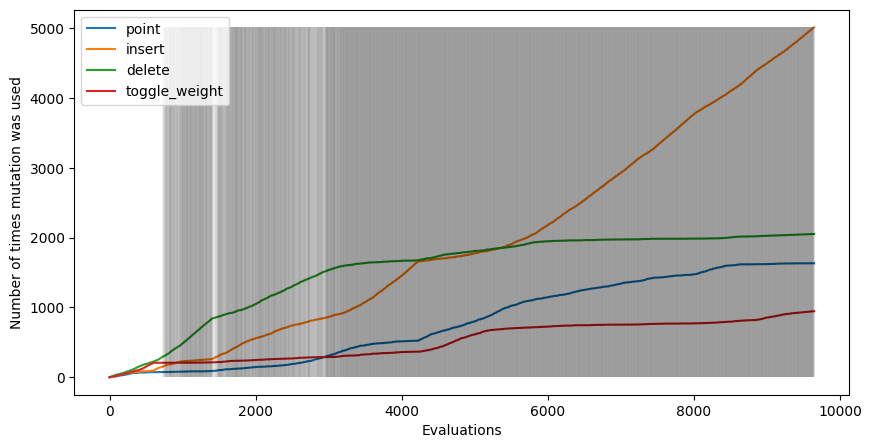

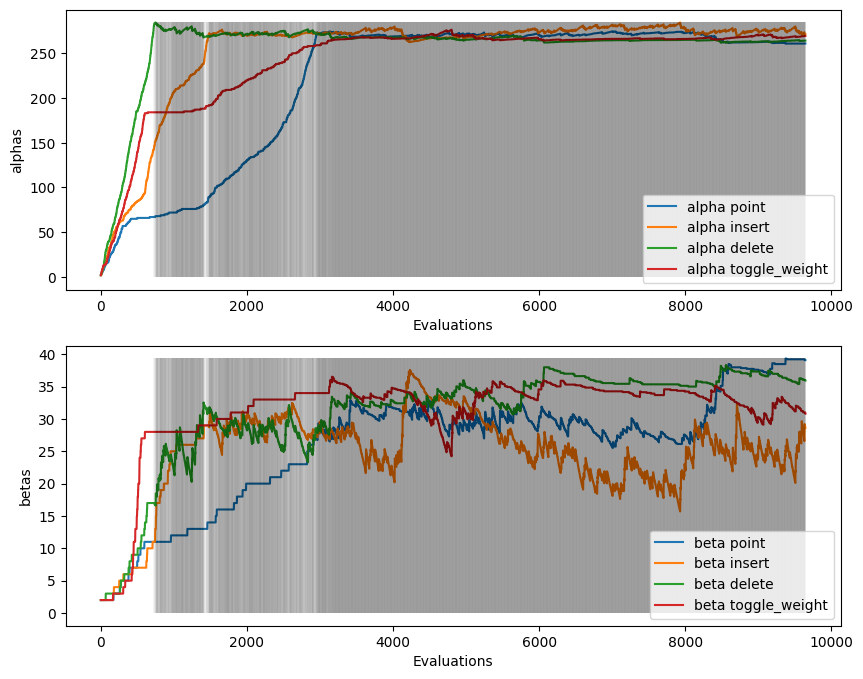

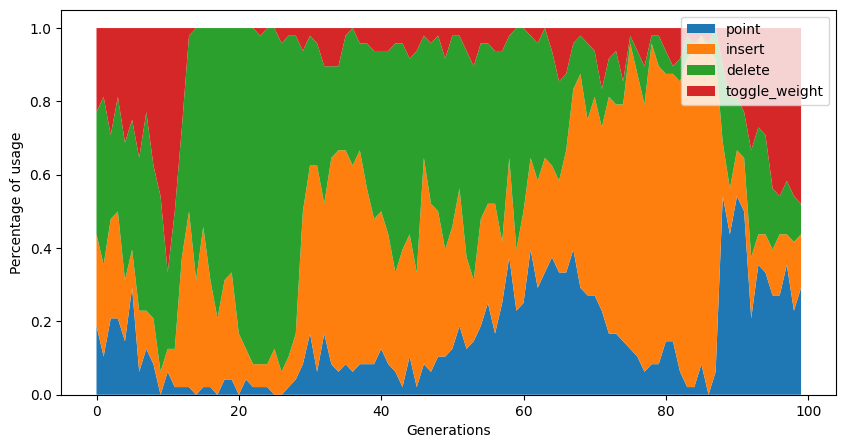

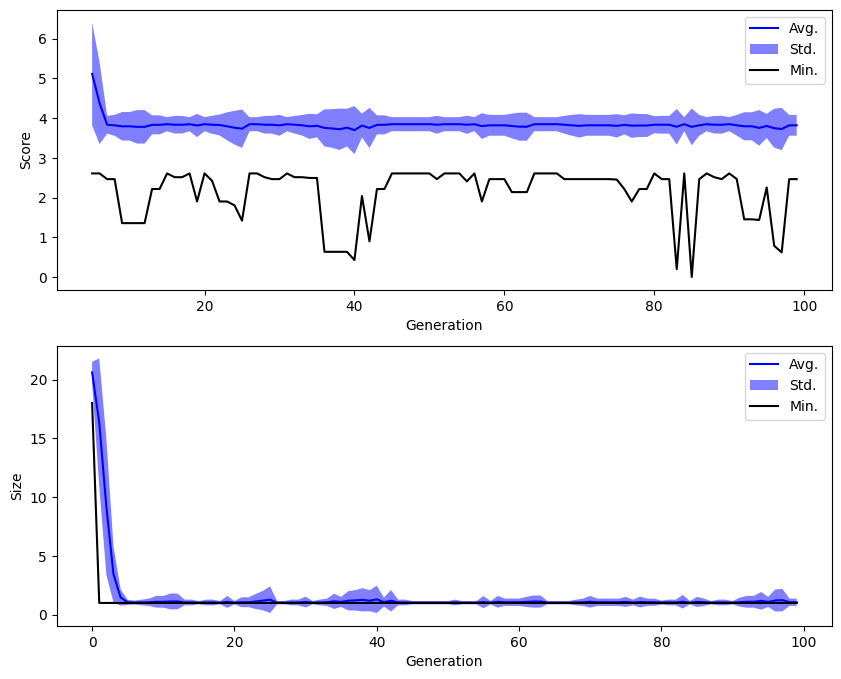

In [5]:
def generate_plots():
    !pip install matplotlib > /dev/null
    import matplotlib.pyplot as plt
    
    # plot the cumulative number of pulls (for evaluations, not generations) ---
    data = np.zeros( (learner_log.shape[0]+1, 4) )
    for i, row in learner_log.iterrows():
        data[i+1, :] = data[i]
        data[i+1, row['arm idx'].astype(int)] += 1

    plt.figure(figsize=(10, 5))

    plt.plot(data, label=est_mab.mutations_)
    plt.xlabel("Evaluations")
    plt.ylabel("Number of times mutation was used")

    # multiple lines all full height showing when D-TS used the dynamic update rule
    plt.vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
               ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)

    plt.legend()
    plt.show()

    # --------------------------------------------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    for i, col in enumerate(['alpha', 'beta']):
        columns = learner_log.columns[learner_log.columns.str.startswith(f'{col} ')]
        labels  = [columns[i].replace(str(i), est_mab.mutations_[i]) for i in range(4)] 
        data    = learner_log.loc[:, columns]

        axs[i].plot(data, label=labels)
        axs[i].set_xlabel("Evaluations")
        axs[i].set_ylabel(f"{col}s")
        axs[i].legend()

        # multiple lines all full height showing when D-TS used the dynamic update rule
        axs[i].vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
                ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)

    plt.show()

    # Approximating the percentage of usage for each generation ----------------
    data = np.zeros( (kwargs['max_gen'], 4) )
    for g in range(kwargs['max_gen']):
        idx_start = g*(learner_log.shape[0]%kwargs['max_gen'])
        idx_end   = (g+1)*(learner_log.shape[0]%kwargs['max_gen'])

        df_in_range = learner_log.iloc[idx_start:idx_end]
        g_data = df_in_range['arm idx'].value_counts(normalize=True).to_dict()
        for k, v in g_data.items():
            data[g, k] = v

    plt.figure(figsize=(10, 5))

    #plt.plot(data, label=est_mab.mutations_)
    plt.stackplot(range(kwargs['max_gen']), data.T, labels=est_mab.mutations_)
    plt.xlabel("Generations")
    plt.ylabel("Percentage of usage")

    plt.legend()
    plt.show()

    # --------------------------------------------------------------------------
    logbook = pd.DataFrame(columns=['gen', 'evals', 'ave m1', 'ave m2',
                                    'std m1', 'std m2', 'min m1', 'min m2'])
    for item in est_mab.logbook_:
        # I'll store the calculate
        logbook.loc[item['gen']] = (
            item['gen'], item['evals'], *item['ave'], *item['std'], *item['min']
        )

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    x = logbook['gen']
    for i, metric in enumerate(['m1', 'm2']):
        y     = logbook[f'ave {metric}']
        y_err = logbook[f'std {metric}']
        y_min = logbook[f'min {metric}']

        axs[i].plot(x, y, 'b', label='Avg.')
        axs[i].fill_between(x, y-y_err, y+y_err, fc='b', alpha=0.5, label="Std.")
        axs[i].plot(x, y_min, 'k', label='Min.')

        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Score" if metric=='m1' else "Size")
        axs[i].legend()

    plt.show()

generate_plots()

## Classification problem

In [6]:
if __name__ == '__main__':
    from brush import BrushClassifier
    
    import warnings
    warnings.filterwarnings("ignore")

    from pmlb import fetch_data

    # X, y = fetch_data('adult', return_X_y=True, local_cache_dir='./')

    data = pd.read_csv('../../docs/examples/datasets/d_analcatdata_aids.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : False,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            est = BrushClassifier(**kwargs).fit(X,y)
            est_mab = BrushClassifierMod(**kwargs).fit(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 


Brush version Original                                                      
metric           score                                         best model   
run 0             0.72  0.02*Div(If(AIDS>68817.00,1445.51,0.01*Total),...  \
run 1             0.84  Logistic(Max(Prod(Sin(0.26*AIDS),-2.70),-3.12,...   
run 2             0.84  Logistic(Asin(Cos(Min(Median(Sqrt(Max(Sub(0.97...   
run 3             0.76         Logistic(Mean(-0.00*Total,0.98,0.02*AIDS))   
run 4             0.82  Logistic(Log1p(Mul(Sinh(Tan(Log1p(Atan(Logabs(...   
run 5             0.70  Logistic(Min(Add(1.00,Add(1.00,1.00)),0.00*AID...   
run 6             0.74  Logistic(Logabs(0.97*Min(0.01*AIDS,Acos(Sqrtab...   
run 7             0.76  Logistic(Min(0.00*AIDS,Cos(Median(Total,1.00*A...   
run 8             0.86  Logistic(2.77*Cos(1.00*Mean(4.99,Total,0.64*AI...   
run 9             0.78  Logistic(Div(Mean(Median(231.31*AIDS,5077.12),...   
run 10            0.68  Logistic(1.20*Sub(0.00*AIDS,Min(0.64*AIDS,Tota...   
run 11            0.76       Prod(Add(0.00*Total,-1.86*AIDS),-0.00*Total)   
run 12            0.78  Mean(1.65,1.63,4.71,Logabs(If(AIDS>68817.00,-0...   
run 13            0.64                                          0.00*AIDS   
run 14            0.82  Logistic(Max(Atan(Sinh(Mean(Sin(Min(Tan(1.00*A...   
run 15            0.84  Logistic(Cos(Abs(Mean(Max(Mean(Tan(Log(Sinh(At...   
run 16            0.88  Logistic(Cos(Add(Mean(Cos(Min(-0.01*AIDS,Total...   
run 17            0.76  Cos(Median(Mul(0.99,Sqrt(Median(0.99*Total,2.9...   
run 18            0.68                                Add(0.40,0.00*AIDS)   
run 19            0.68                      Logistic(0.04*Tan(1.00*AIDS))   
run 20            0.78    Logistic(Logabs(Div(2504.30*AIDS,-1.72*Total)))   
run 21            0.82  Logistic(Cos(Mean(-12.35,-4.03,Median(Prod(1.0...   
run 22            0.76     Logistic(0.40*Tan(Mean(Sqrt(1.09*AIDS),AIDS)))   
run 23            0.74         Logistic(Sin(Add(Log1p(0.04*AIDS),Total)))   
run 24            0.68                          Mean(0.78,0.41,0.00*AIDS)   
run 25            0.70    Logistic(-1.27*Cos(1.00*Sum(Total,Total,AIDS)))   
run 26            0.70  Logistic(-0.82*Sin(1.00*Mean(AIDS,1.00*Total,T...   
run 27            0.72                   Logistic(Cos(-69.57*Cos(Total)))   
run 28            0.76  Logistic(Median(Sub(129.64*AIDS,0.08*Total),AI...   
run 29            0.66                     Logistic(-0.45*Tan(7.74*AIDS))   

Brush version            Modified   
metric        size depth    score   
run 0            6     2     0.72  \
run 1           13     6     0.76   
run 2           15     8     0.68   
run 3            5     2     0.68   
run 4           12     9     0.68   
run 5           12     4     0.76   
run 6            9     6     0.78   
run 7           11     5     0.68   
run 8            6     3     0.68   
run 9            9     4     0.82   
run 10           8     3     0.68   
run 11           5     2     0.86   
run 12          10     4     0.78   
run 13           1     0     0.78   
run 14          13     8     0.80   
run 15          20    10     0.70   
run 16          16     6     0.80   
run 17          14     5     0.78   
run 18           3     1     0.68   
run 19           3     2     0.68   
run 20           5     3     0.74   
run 21          15     5     0.68   
run 22           6     4     0.68   
run 23           6     4     0.78   
run 24           4     1     0.82   
run 25           6     3     0.80   
run 26           6     3     0.68   
run 27           4     3     0.80   
run 28           6     3     0.74   
run 29           3     2     0.68   

Brush version                                                                 
metric                                                best model size depth   
run 0          Logistic(Cos(Mean(Sub(1.00*Total,-3.58),1.00*A...    7     4  \
run 1          Logistic(1.64*Cos(1.00*Median(1.00*AIDS,1.00*P...   13     6   
run 2                             

Brush version   Original                         Modified              
metric             score       size      depth      score       size   
count          30.000000  30.000000  30.000000  30.000000  30.000000  \
mean            0.755333   8.400000   4.033333   0.739333   7.066667   
std             0.064259   4.716808   2.413801   0.057412   3.777733   
min             0.640000   1.000000   0.000000   0.680000   2.000000   
25%             0.700000   5.000000   2.250000   0.680000   4.000000   
50%             0.760000   6.000000   3.500000   0.740000   5.500000   
75%             0.810000  12.000000   5.000000   0.780000   9.000000   
max             0.880000  20.000000  10.000000   0.860000  16.000000   

Brush version                                                         
metric             depth point mutation calls insert mutation calls   
count          30.000000            30.000000             30.000000  \
mean            3.366667          3707.366667           2702.500000   
std             1.425950           855.867355            394.091513   
min             1.000000          2694.000000           1976.000000   
25%             2.000000          3125.250000           2532.500000   
50%             3.000000          3496.500000           2674.000000   
75%             4.000000          3894.750000           2897.750000   
max             6.000000          6644.000000           3869.000000   

Brush version                                                     
metric        delete mutation calls toggle_weight mutation calls  
count                     30.000000                    30.000000  
mean                    1999.566667                  1238.566667  
std                      483.568965                   513.808275  
min                      609.000000                    85.000000  
25%                     1765.500000                   988.500000  
50%                     2033.500000                  1399.000000  
75%                     2375.750000                  1604.000000  
max                     2600.000000                  1861.000000

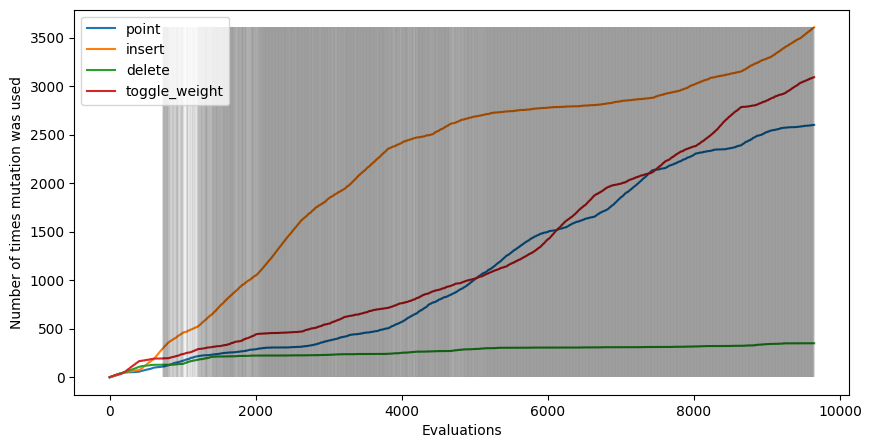

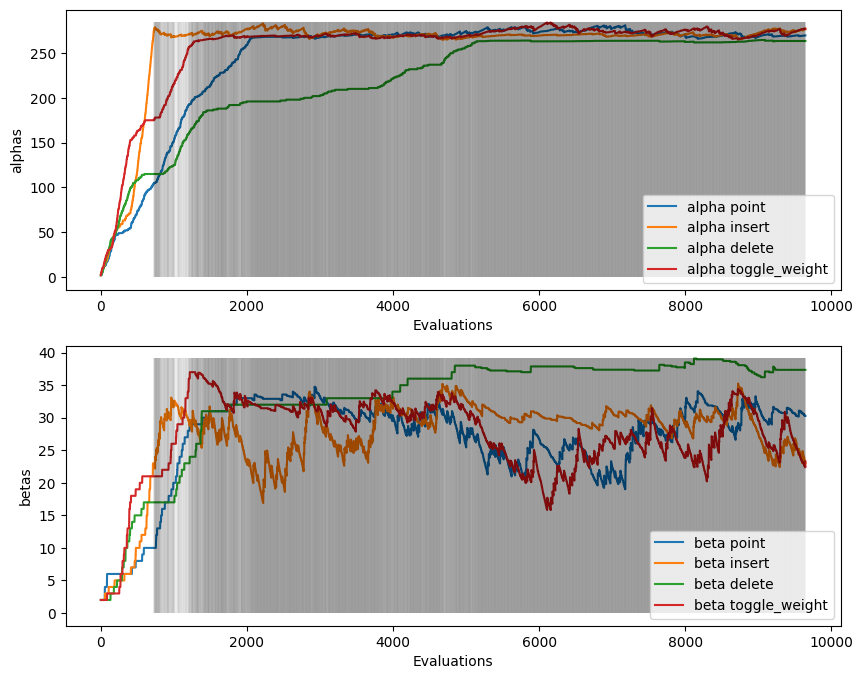

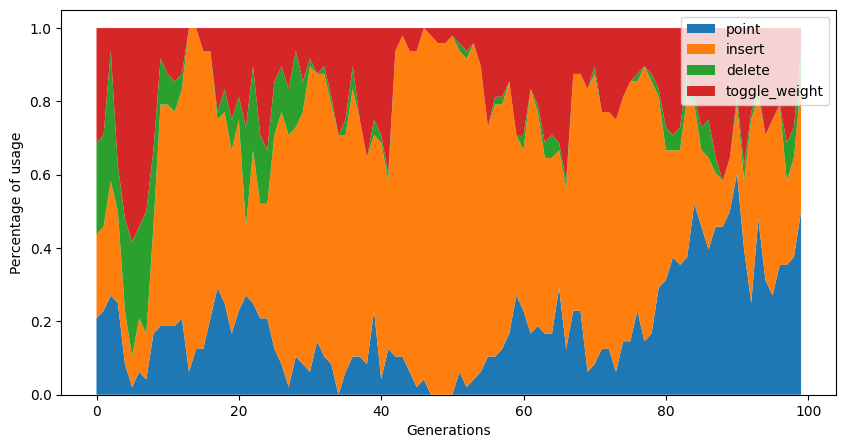

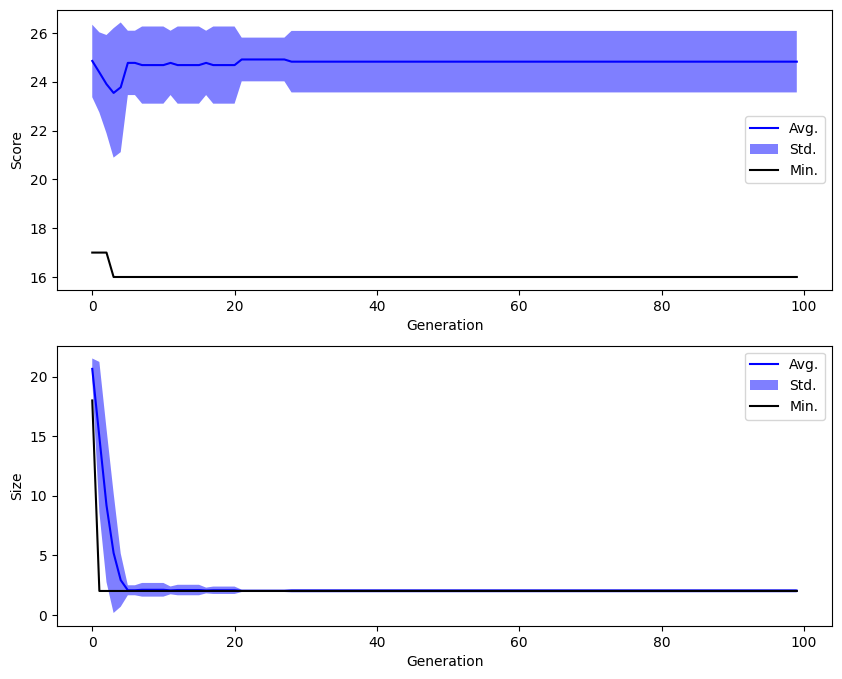

In [7]:
generate_plots()